In [1]:

# Install necessary libraries
# !pip install transformers pandas scikit-learn torch
# or conda defined environment

# Environment setting

In [2]:
# Import libraries
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# If Metal Performance Shader (mps) is not available tell me:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

# If mps is available directly put it on the device.
else:
    device = torch.device("mps")
,
# If cuda (nvidia gpu) is not available tell me:
if not torch.cuda.is_available():
    print("Cuda not available because the current PyTorch install was not "
              "built with Cuda enabled.")
   

# If cuda is available directly put it on the device.
else:
    device = torch.device("cuda")
,

# If neither cuda and mps are available, set device to "cpu"
if not torch.backends.mps.is_available():
    if not torch.cuda.is_available():
        print("Neither Cuda nor MPS are available")
        device = torch.device("cpu")

,
# Is mps available?

mps_avail = torch.backends.mps.is_available() 
print(f"Is Metal Performance Shader (mps) available? {mps_avail}")

,

# Is mps available?

cuda_avail = torch.cuda.is_available() 
print(f"Is Cuda available? {cuda_avail}")

print("gpu device: ", device)


Cuda not available because the current PyTorch install was not built with Cuda enabled.
Is Metal Performance Shader (mps) available? True
Is Cuda available? False


In [4]:
print("gpu device: ", device)

gpu device:  mps


In [5]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# Setting seed:

def set_seed_fun(seed_number: int):
    """
    We could also use pytorch_lightning package
    try:
        import pytorch_lightning as pl
    except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
        !pip install --quiet pytorch-lightning>=1.5
        import pytorch_lightning as pl
    
    pl.seed_everything(42)
    """
    np.random.seed(seed_number)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed_number)
    if torch.cuda.is_available():
        torch.manual_seed(seed_number)
        torch.cuda.manual_seed(seed_number)
        torch.cuda.manual_seed_all(seed_number)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchark = False

set_seed_fun(42)


'\nWe could also use pytorch_lightning package\ntry:\n    import pytorch_lightning as pl\nexcept ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary\n    !pip install --quiet pytorch-lightning>=1.5\n    import pytorch_lightning as pl\n\npl.seed_everything(42)\n'

# Function definitions

## Embedding function

In [7]:
# Function to generate embeddings with RoBERTa
def generate_embeddings(texts, tokenizer, model):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length').to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(embedding)
    return np.vstack(embeddings)

## Class functions

Definition of functions to:
- Transform a data set into the good format
- create a simple neural network architecture
- create a funtion to transform seconds into a list of (hours, minutes, seconds)

In [8]:
# Define a Dataset class for PyTorch
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)



In [9]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(p=0.6)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(p=0.6)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [10]:
def sec2hms(ss):
	(hh, ss)=divmod(ss, 3600)
	(mm, ss)=divmod(ss, 60)
	return (hh, mm, ss)

## Training function

Definition of the training function.

In [11]:
# Function to train the model
def train_model(X_train, y_train, X_val, y_val, input_size):
    train_dataset = NewsDataset(X_train, y_train)
    val_dataset = NewsDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = SimpleNN(input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

    num_epochs = 16
    best_val_loss = float('inf')
    patience = 2
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    return model

# Training part

## Loading of the dataset 

In [12]:
# Load data from Google Drive
# data_path = '/content/drive/My Drive/final_combined_dataset.csv'
# df = pd.read_csv(data_path)
df = pd.read_csv("final_combined_dataset.csv")

In [13]:
## Just in case of bug: to check where we are in the directories

#import os

#cwd = os.getcwd()  # Get the current working directory (cwd)
#files = os.listdir(cwd)  # Get all the files in that directory
#print("Files in %r: %s" % (cwd, files))

## Model initialization

In [14]:
#####################################
# benchmark beginning for embedding #
#####################################
time_start_embed = time.perf_counter()

In [15]:
# Initialize RoBERTa for embeddings
model_name = 'roberta-base'

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
embedding_model = RobertaModel.from_pretrained('roberta-base').to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Prepare data
X = df['Text'].values.astype(str)
y = (df['Label'] == 'fake').astype(int).values


## Splitting

In [17]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


## Embedding

In [18]:
# Generate embeddings
X_train_embeddings = generate_embeddings(X_train, roberta_tokenizer, embedding_model)
X_val_embeddings = generate_embeddings(X_val, roberta_tokenizer, embedding_model)
X_test_embeddings = generate_embeddings(X_test, roberta_tokenizer, embedding_model)


In [19]:
#####################################
# benchmark ending for embedding    #
#####################################
time_end_embed = time.perf_counter()

## Training

In [20]:
#####################################
# benchmark beginning for modeling  #
#####################################
time_start_model = time.perf_counter()

In [21]:
# Define the embedding size
input_size = 768  # Embedding size generated by RoBERTa


In [22]:
# Train the model
model = train_model(X_train_embeddings, y_train, X_val_embeddings, y_val, input_size)


Epoch 1/16, Validation Loss: 0.4897132058476293
Epoch 2/16, Validation Loss: 0.3468424047148505
Epoch 3/16, Validation Loss: 0.3147446128518082
Epoch 4/16, Validation Loss: 0.299121203464131
Epoch 5/16, Validation Loss: 0.29044570617897564
Epoch 6/16, Validation Loss: 0.283991978612057
Epoch 7/16, Validation Loss: 0.28022531714550286
Epoch 8/16, Validation Loss: 0.27605019821677096
Epoch 9/16, Validation Loss: 0.27410644777985504
Epoch 10/16, Validation Loss: 0.2703310531932254
Epoch 11/16, Validation Loss: 0.27073535565720047
Epoch 12/16, Validation Loss: 0.27711832939192305
Early stopping


In [23]:
#####################################
# benchmark ending for modeling     #
#####################################
time_end_model = time.perf_counter()

## Evaluating

In [24]:
# Evaluate the model on the test set
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch in torch.tensor(X_test_embeddings, dtype=torch.float32).to(device):
        outputs = model(X_batch.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted.cpu().numpy()[0])


In [25]:
# Evaluate performance
acc = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["real", "fake"])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc}")
print(f"Classification Report:{class_report}")
print(f"Confusion Matrix:{conf_matrix}")


Accuracy: 0.8837463556851312
Classification Report:              precision    recall  f1-score   support

        real       0.87      0.91      0.89      1413
        fake       0.90      0.85      0.88      1331

    accuracy                           0.88      2744
   macro avg       0.89      0.88      0.88      2744
weighted avg       0.88      0.88      0.88      2744

Confusion Matrix:[[1290  123]
 [ 196 1135]]


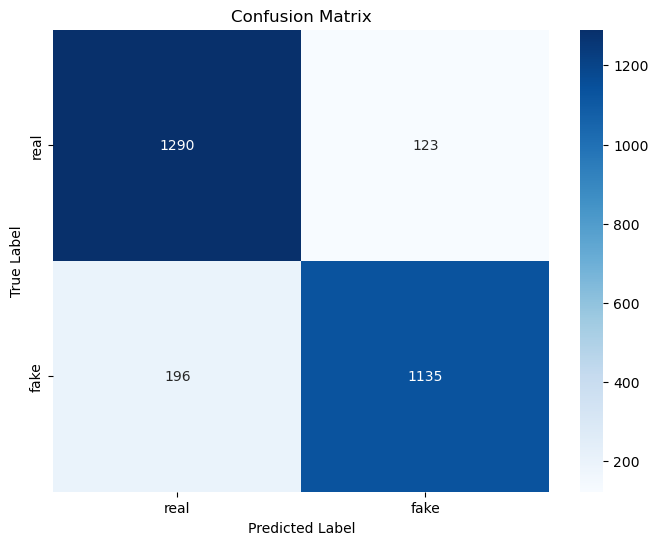

In [26]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Benchmark results

In [27]:
#####################################
#          Benchmark results        #
#####################################
# calculating the performances
embedding_duration = time_end_embed - time_start_embed
modeling_duration = time_end_model - time_start_model

# formating
embedding_duration_hms = sec2hms(embedding_duration)
modeling_duration_hms = sec2hms(modeling_duration)

# printing the embedding and modeling performances

print(f'Embedding duration : {embedding_duration_hms[0]:.0f}:{embedding_duration_hms[1]:.0f}:{embedding_duration_hms[2]:.3f}')
print(f'Modeling duration : {modeling_duration_hms[0]:.0f}:{modeling_duration_hms[1]:.0f}:{modeling_duration_hms[2]:.3f}')

Embedding duration : 0:13:33.632
Modeling duration : 0:0:13.328


In [28]:
## we should write a function with an if else condition for when a drive is in and where there's not
# Save the trained model to Google Drive
# final_model_path = '/content/drive/My Drive/fake_news_model_roberta3.pth'
# torch.save(model.state_dict(), final_model_path)
# print(f"Model saved to: {final_model_path}")
torch.save(model.state_dict(), model_name + "_model.tar")
